This is to start exporing gap filling

In [1]:
%matplotlib inline

import os
from pathlib import Path
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
import dill
from scipy import io
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GRU
from keras import regularizers
from keras import optimizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
#My helper functions
from modelNN_functions import assessTrainTestData
from modelNN_functions import plotConfusionMatrix
from modelNN_functions import pandasToMat

Using TensorFlow backend.


In [48]:
#dill.dump_session('notebook_fillModel.db')
#dill.load_session('notebook_fillModel.db')

In [2]:
def runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, predictTargets, 
               epochCount, batchCount, numFeatures):

    """
    where: 
        featureTrain = features used in training the model
        targetTrain = targets (verified water level obs) used in training the model
        featureTest = features used for validation
        targetTest = targets (verified water level obs) used for valdation
        predictFeatures = the features for the model predictions
        predictTargets = the targets for the model predictions
        epochCount = number of training cycles to use for NN model (10-20 seems reasonable)
        batchCount = the batch size to use when training (somewhere from 32-256 seems reasonable)
        numFeatures = the number of input features in the NN model
    """

    #First define the keras NN framework to be used
    # For a regression model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=numFeatures))
    #model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu', input_dim=numFeatures))
    #model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu', input_dim=numFeatures))
    model.add(Dense(1))
    #Changing the learning rate from 0.001 (default) to speed up convergence
    adamOpt = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=adamOpt,
                  loss='mse',
                  metrics=['mae'])
    
    #Set up the model checkpoint
    # checkpoint
    filepath="fillmodel_best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    
    # Train the model, iterating on the data in batches of X # samples (somewhere between 32 - 256)
    history = model.fit(featureTrain, targetTrain, epochs=epochCount, batch_size=batchCount, validation_data=(featureTest, targetTest),callbacks=callbacks_list)
    
    #Evaulate the model
    eval_model=model.evaluate(featureTest, targetTest)
    eval_model
    
    #Plot the NN loss over each epoch
    fig, ax = plt.subplots()
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.legend(['Training','Validation'])
    plt.show()
    #fig.savefig('NN_modelTrainingHistory.png')

    #Generate model predictions for the validation period
    #modelPrediction = model.predict(predictFeatures, batch_size=32)
    
    modelOut = pd.DataFrame()
    #modelOut['verified'] = predictTargets['verified']
    #modelOut['modelPrediction']=modelPrediction[:,0]    
    
    return modelOut, model


In [3]:
cleaned = pd.read_pickle(Path("pickle_files/8536110_cm_raw_ver_merged_wl_Cleaned"))
neighbor = pd.read_pickle(Path("pickle_files/8557380_lewes_raw_ver_merged_wl_Cleaned"))

#cleaned = pd.read_pickle(Path("pickle_files/8557380_lewes_raw_ver_merged_wl_Cleaned"))
#neighbor = pd.read_pickle(Path("pickle_files/8536110_cm_raw_ver_merged_wl_Cleaned"))

#cleaned = pd.read_pickle(Path("pickle_files/8534720_ac_raw_ver_merged_wl_Cleaned"))
#neighbor = pd.read_pickle(Path("pickle_files/8536110_cm_raw_ver_merged_wl_Cleaned"))

#cleaned = pd.read_pickle(Path("pickle_files/8443970_boston_raw_ver_merged_wl_Cleaned"))
#neighbor = pd.read_pickle(Path("pickle_files/8418150_portland_raw_ver_merged_wl_Cleaned"))

#cleaned = pd.read_pickle(Path("pickle_files/8418150_portland_raw_ver_merged_wl_Cleaned"))
#neighbor = pd.read_pickle(Path("pickle_files/8443970_boston_raw_ver_merged_wl_Cleaned"))


In [4]:
#IMPT if you run this cell twice it will mess up since I am replacing all the NaNs (e.g. the next time through will have none)

primaryTrue = cleaned['primary'].notnull()
cleaned['primaryTrue'] = primaryTrue * 1

sigmaTrue = cleaned['sigma'].notnull()
cleaned['sigmaTrue'] = sigmaTrue * 1

backupTrue = cleaned['backup'].notnull()
cleaned['backupTrue'] = backupTrue * 1

cleaned['primary'].fillna(value=0, inplace = True)
cleaned['sigma'].fillna(value=0, inplace = True)
cleaned['backup'].fillna(value=0, inplace = True)
cleaned['residual'].fillna(value=0, inplace = True)
cleaned['targets'].fillna(value=0, inplace = True)

#If the primary or residual was deamed bad, we should also be setting the value to 0, since it would be dropped
cleaned['primary']=cleaned['primary']*cleaned['targets']
cleaned['primaryTrue']=cleaned['primaryTrue']*cleaned['targets']
cleaned['residual']=cleaned['residual']*cleaned['targets']


In [5]:
# THIS IS THE SAME PROCESS BUT FOR THE NEIGHBOR STATION RESIDUAL

neighborResidualTrue = neighbor['residual'].notnull()
neighbor['residualTrue'] = neighborResidualTrue * 1

neighbor['residual'].fillna(value=0, inplace = True)
neighbor['targets'].fillna(value=0, inplace = True)

neighbor['residual']=neighbor['residual']*neighbor['targets']
neighbor['residualTrue']=neighbor['residualTrue']*neighbor['targets']

In [6]:
#Now add neighbor residual to the main cleaned dataframe
cleaned['neighborResidual']=neighbor['residual']
cleaned['neighborResidualTrue']=neighbor['residualTrue']

In [7]:
cleaned['backupTrue'] = cleaned['backupTrue'].mask(cleaned['backup'].abs() >4, 0)
cleaned['backup'] = cleaned['backup'].mask(cleaned['backup'].abs() >4, 0)
cleaned['backupResidual'] = (cleaned['backup']-cleaned['prediction']) * cleaned['backupTrue']

cleaned['sigma'] = cleaned['sigma'].mask(cleaned['sigma'].abs() > 1, 1)



In [8]:
#Scaling - trying scaling by the Great Diurnal range, and NOT scaling residual.  The residual is fairly normally distributed about 0 and the observed and predicted values run pretty consistently 
#between -1 and 1 when scaled by the GDT range.

CapeMayRange=1.659
GDTrange = CapeMayRange

#What columns are being Scaled
names = ['primary','backup','prediction']
# Fit your data on the scaler object
cleanedScaled=cleaned.copy()
cleanedScaled.loc[:,names] = cleanedScaled.loc[:,names] / GDTrange

cleanedScaled.head()

,primary,sigma,backup,verified,prediction,residual,targets,primaryTrue,sigmaTrue,backupTrue,neighborResidual,neighborResidualTrue,backupResidual
time,,,,,,,,,,,,,
2007-01-01 00:00:00,0.276673,0.006,0.268837,0.459,0.232068,0.074,1.0,1.0,1,1,0.068,1.0,0.061
2007-01-01 00:06:00,0.263412,0.005,0.256178,0.437,0.220012,0.072,1.0,1.0,1,1,0.064,1.0,0.060
2007-01-01 00:12:00,0.241109,0.006,0.233876,0.400,0.207354,0.056,1.0,1.0,1,1,0.055,1.0,0.044
2007-01-01 00:18:00,0.226643,0.006,0.218807,0.376,0.193490,0.055,1.0,1.0,1,1,0.059,1.0,0.042
2007-01-01 00:24:00,0.213382,0.006,0.206148,0.354,0.179024,0.057,1.0,1.0,1,1,0.042,1.0,0.045


In [30]:
%%time
#Add a feature for primary, which effectively estimates the gap width.  So how many points forward and backward
#in time until I have a good value (up to some maximum distance - thinking of using 12 hours

#primaryTF = cleaned['primaryTrue'].where(cleaned['primaryTrue'] == 1)
primaryTF = cleaned['primaryTrue']
primaryTF = primaryTF.reset_index()
primaryTF.drop(['time'], axis=1,inplace = True)
prevGap = primaryTF.copy()*0

for row in primaryTF.iloc[1:10].itertuples():
    ind = row[0]
    #if (primaryTF.iloc[ind-1] == 1) and (primaryTF.iloc[ind+1] == 1):
    if primaryTF.primaryTrue.iloc[ind] == 1:
        print(primaryTF.primaryTrue.iloc[ind])

    
    
   # startIndex=indexStop-120
    #if startIndex < 0:
     #   startIndex = 0
    #values = primaryTF.iloc[startIndex:indexStop]
    #prevGap.iloc[indexStop] = values.last_valid_index()



1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
CPU times: user 20.4 ms, sys: 98 µs, total: 20.5 ms
Wall time: 18.6 ms


In [24]:
primaryTF.iloc[1]

primaryTrue    1.0
Name: 1, dtype: float64

In [9]:
#Now create a previous 6 and 12 minute value and following 6 and 12 minute value of the primary (and boolean) and the residual (and boolean)
#Prev 6 min
cleanedScaled['primaryPrev6']=cleanedScaled['primary'].shift(periods = 1)
cleanedScaled['primaryTruePrev6']=cleanedScaled['primaryTrue'].shift(periods = 1)
cleanedScaled['residualPrev6']=cleanedScaled['residual'].shift(periods = 1)
#Prev 12 min
cleanedScaled['primaryPrev12']=cleanedScaled['primary'].shift(periods = 2)
cleanedScaled['primaryTruePrev12']=cleanedScaled['primaryTrue'].shift(periods = 2)
cleanedScaled['residualPrev12']=cleanedScaled['residual'].shift(periods = 2)
#Prev 18 min
cleanedScaled['primaryPrev18']=cleanedScaled['primary'].shift(periods = 3)
cleanedScaled['primaryTruePrev18']=cleanedScaled['primaryTrue'].shift(periods = 3)
cleanedScaled['residualPrev18']=cleanedScaled['residual'].shift(periods = 3)

#Next 6 min
cleanedScaled['primaryNext6']=cleanedScaled['primary'].shift(periods = -1)
cleanedScaled['primaryTrueNext6']=cleanedScaled['primaryTrue'].shift(periods = -1)
cleanedScaled['residualNext6']=cleanedScaled['residual'].shift(periods = -1)
#Next 12 min
cleanedScaled['primaryNext12']=cleanedScaled['primary'].shift(periods = -2)
cleanedScaled['primaryTrueNext12']=cleanedScaled['primaryTrue'].shift(periods = -2)
cleanedScaled['residualNext12']=cleanedScaled['residual'].shift(periods = -2)
#Next 18 min
cleanedScaled['primaryNext18']=cleanedScaled['primary'].shift(periods = -3)
cleanedScaled['primaryTrueNext18']=cleanedScaled['primaryTrue'].shift(periods = -3)
cleanedScaled['residualNext18']=cleanedScaled['residual'].shift(periods = -3)


#And drop the first and last 18 minutes (3points)
cleanedScaled.drop(cleanedScaled.head(3).index, inplace=True)
cleanedScaled.drop(cleanedScaled.tail(3).index, inplace=True)

#Just to be sure - drop any nan values (though I think all of these should have already been set to 0)
cleanedScaled = cleanedScaled.dropna()

cleanedScaled

,primary,sigma,backup,verified,prediction,residual,targets,primaryTrue,sigmaTrue,backupTrue,...,residualPrev18,primaryNext6,primaryTrueNext6,residualNext6,primaryNext12,primaryTrueNext12,residualNext12,primaryNext18,primaryTrueNext18,residualNext18
time,,,,,,,,,,,,,,,,,,,,,
2007-01-01 00:18:00,0.226643,0.006,0.218807,0.376,0.193490,0.055,1.0,1.0,1,1,...,0.074,0.213382,1.0,0.057,0.201929,1.0,0.063,0.184448,1.0,0.061
2007-01-01 00:24:00,0.213382,0.006,0.206148,0.354,0.179024,0.057,1.0,1.0,1,1,...,0.072,0.201929,1.0,0.063,0.184448,1.0,0.061,0.171187,1.0,0.067
2007-01-01 00:30:00,0.201929,0.004,0.195298,0.335,0.163954,0.063,1.0,1.0,1,1,...,0.056,0.184448,1.0,0.061,0.171187,1.0,0.067,0.155515,1.0,0.070
2007-01-01 00:36:00,0.184448,0.008,0.177818,0.306,0.147679,0.061,1.0,1.0,1,1,...,0.055,0.171187,1.0,0.067,0.155515,1.0,0.070,0.132610,1.0,0.062
2007-01-01 00:42:00,0.171187,0.004,0.165160,0.284,0.130802,0.067,1.0,1.0,1,1,...,0.057,0.155515,1.0,0.070,0.132610,1.0,0.062,0.111513,1.0,0.058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 23:12:00,0.338758,0.020,0.359855,0.562,0.376733,-0.063,1.0,1.0,1,1,...,-0.054,0.344786,1.0,-0.071,0.352019,1.0,-0.074,0.368294,1.0,-0.059
2017-12-31 23:18:00,0.344786,0.023,0.366486,0.572,0.387583,-0.071,1.0,1.0,1,1,...,-0.052,0.352019,1.0,-0.074,0.368294,1.0,-0.059,0.367691,1.0,-0.071
2017-12-31 23:24:00,0.352019,0.022,0.374925,0.584,0.396624,-0.074,1.0,1.0,1,1,...,-0.063,0.368294,1.0,-0.059,0.367691,1.0,-0.071,0.368294,1.0,-0.077


In [10]:
trainScaled = cleanedScaled.loc[:'2014-12-31 23:54:00']
testScaled = cleanedScaled.loc['2015-01-01 00:00:00':]

In [11]:
#For the test data (and potentially for training data) we are going to remove the cases where the primary was used, 
#since we are trying to only assess times when humans filled the data.
testScaled = testScaled[testScaled.targets == 0]
#trainScaled = trainScaled[trainScaled.targets == 0]

In [ ]:
#This cell is to cat the initial 5 training sets together.  Right now just using 1 however.

#capeMayTrain=trainScaled.copy()
#capeMayTest=testScaled.copy()
#capeMayTrain['stationName']='Cape May'
#capeMayTest['stationName']='Cape May'

#lewesTrain=trainScaled.copy()
#lewesTest=testScaled.copy()
#lewesTrain['stationName']='Lewes'
#lewesTest['stationName']='Lewes'

#acTrain=trainScaled.copy()
#acTest=testScaled.copy()
#acTrain['stationName']='Atlantic City'
#acTest['stationName']='Atlantic City'

#bostonTrain=trainScaled.copy()
#bostonTest=testScaled.copy()
#bostonTrain['stationName']='Boston'
#bostonTest['stationName']='Boston'

#portlandTrain=trainScaled.copy()
#portlandTest=testScaled.copy()
#portlandTrain['stationName']='Portland'
#portlandTest['stationName']='Portland'


In [ ]:
#Only run this cell if combining multiple stations together in one dataframe

#del trainScaled
#del testScaled
#trainScaled = pd.concat([capeMayTrain, lewesTrain, acTrain, bostonTrain, portlandTrain])
#testScaled = pd.concat([capeMayTest, lewesTest, acTest, bostonTest, portlandTest])

In [12]:
print('Total Training Points = ' + str(trainScaled.shape[0]))
print('Total Testing Points = ' + str(testScaled.shape[0]))

Total Training Points = 698182
Total Testing Points = 5175


In [13]:
trainRand=shuffle(trainScaled)
testRand=shuffle(testScaled)

In [14]:
# New Feature Set
featureNames = ['primaryPrev6','primaryPrev12','primaryPrev18','primaryNext6','primaryNext12','primaryNext18','backup','prediction','residualPrev6',
                              'residualPrev12','residualPrev18','residualNext6','residualNext12','residualNext18','primaryTruePrev6','primaryTruePrev12','primaryTruePrev18','primaryTrueNext6',
                              'primaryTrueNext12','primaryTrueNext18','backupTrue','neighborResidual','neighborResidualTrue','backupResidual']

featureTrain = trainRand.loc[:,featureNames]
featureTest = testRand.loc[:,featureNames]
targetTrain=trainRand.loc[:,['verified']]
targetTest=testRand.loc[:,['verified']]

predictFeatures = testScaled.loc[:,featureNames]
predictTargets = testScaled.loc[:,'verified']

In [38]:
len(featureNames)

24

In [ ]:
#Calculate the baseiline error (in this case the error in using the tide predictions alone)
mae_tidePredictions = mean_absolute_error(test['prediction'],test['verified'])
print('mae baseline = '+ str(mae_tidePredictions))

Train on 698182 samples, validate on 5175 samples
Epoch 1/20
698182/698182 [==============================] - 12s 17us/step - loss: 6.5418e-04 - mae: 0.0115 - val_loss: 0.0059 - val_mae: 0.0489
Epoch 2/20
698182/698182 [==============================] - 12s 17us/step - loss: 1.9219e-04 - mae: 0.0092 - val_loss: 0.0043 - val_mae: 0.0450
Epoch 3/20
698182/698182 [==============================] - 12s 17us/step - loss: 1.8004e-04 - mae: 0.0089 - val_loss: 0.0029 - val_mae: 0.0308
Epoch 4/20
698182/698182 [==============================] - 12s 17us/step - loss: 1.6924e-04 - mae: 0.0087 - val_loss: 0.0026 - val_mae: 0.0288
Epoch 5/20
698182/698182 [==============================] - 11s 16us/step - loss: 1.6268e-04 - mae: 0.0084 - val_loss: 0.0024 - val_mae: 0.0282
Epoch 6/20
698182/698182 [==============================] - 11s 16us/step - loss: 1.5874e-04 - mae: 0.0083 - val_loss: 0.0032 - val_mae: 0.0329
Epoch 7/20
698182/698182 [==============================] - 13s 18us/step - loss: 1.54

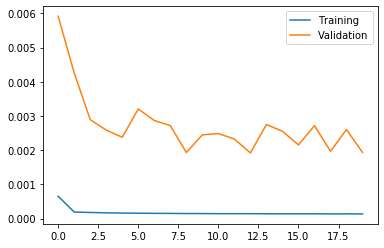

In [16]:
#Going back to trying a standard dense NN with just CM

epochCount = 20
batchCount = 256
numFeatures = len(featureNames)
modelOut, model = runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, predictTargets,
               epochCount, batchCount, numFeatures)

In [20]:
#Load the best simple 5 station model
model = load_model('fillmodel_best.hdf5')

In [21]:
#Generate predictions from the best model
modelPrediction = model.predict(predictFeatures, batch_size=256)

In [24]:
#Generate example predictions for Cape May
#Now for the simple model
modelOut=testScaled.copy()
modelOut['modelPrediction']=modelPrediction

In [36]:
testVerified= cleanedScaled.loc['2015-01-01 00:00:00':,'verified'].to_frame()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5175 entries, 2015-01-11 06:12:00 to 2017-12-14 15:36:00
Data columns (total 24 columns):
primaryPrev6            5175 non-null float64
primaryPrev12           5175 non-null float64
primaryPrev18           5175 non-null float64
primaryNext6            5175 non-null float64
primaryNext12           5175 non-null float64
primaryNext18           5175 non-null float64
backup                  5175 non-null float64
prediction              5175 non-null float64
residualPrev6           5175 non-null float64
residualPrev12          5175 non-null float64
residualPrev18          5175 non-null float64
residualNext6           5175 non-null float64
residualNext12          5175 non-null float64
residualNext18          5175 non-null float64
primaryTruePrev6        5175 non-null float64
primaryTruePrev12       5175 non-null float64
primaryTruePrev18       5175 non-null float64
primaryTrueNext6        5175 non-null float64
primaryTrueNext12       5175 

In [25]:
pandasToMat(modelOut, predictFeatures, 'CapeMayFill')

In [37]:
#This is to output just the entire test verified time series
io.savemat(file_name = 'capeMayVerified.mat', mdict = testVerified.to_dict('list'))

In [30]:
pandasToMat(testVerified, testVerified, 'CapeMayFill_verified')

TypeError: unsupported type: <class 'str'>

In [ ]:
#Initial test with CM data - filling gaps (Using all times to train) - with Standard Scaler

epochCount = 20
batchCount = 256
numFeatures = 23
modelOut, model = runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, predictTargets,
               epochCount, batchCount, numFeatures)

In [ ]:
plt.scatter(modelOut['verified'],modelOut['modelPrediction'])

In [ ]:
pandasToMat(modelOut, predictFeatures, 'Fill_CapeMay')

In [ ]:
#Testing now with Lewes data - filling gaps (Using all times to train) - with Standard Scaler

epochCount = 20
batchCount = 256
numFeatures = 23
modelOut, model = runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, predictTargets,
               epochCount, batchCount, numFeatures)

In [ ]:
plt.scatter(modelOut['verified'],modelOut['modelPrediction'])

In [ ]:
pandasToMat(modelOut, predictFeatures, 'Fill_Lewes')

In [ ]:
#Testing now with AC data - filling gaps (Using all times to train) - with Standard Scaler

epochCount = 20
batchCount = 256
numFeatures = 23
modelOut, model = runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, predictTargets,
               epochCount, batchCount, numFeatures)

In [ ]:
#Testing now with Boston data - filling gaps (Using all times to train) - with Standard Scaler

epochCount = 20
batchCount = 256
numFeatures = 23
modelOut, model = runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, predictTargets,
               epochCount, batchCount, numFeatures)

In [ ]:
#Initial test with all data - filling gaps (Using all times to train) - with Standard Scaler

epochCount = 20
batchCount = 256
numFeatures = 23
modelOut, model = runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, predictTargets,
               epochCount, batchCount, numFeatures)

In [39]:
#This is to prep targets for fitting in scikit-learn
targetTrainIn=np.ravel(targetTrain)
targetTestIn=np.ravel(targetTest)

In [46]:
%%time
# Fitting a linear regression
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(featureTrain, targetTrainIn)

CPU times: user 1 s, sys: 525 ms, total: 1.53 s
Wall time: 541 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
# prediction on the training dataset
mae_train = mean_absolute_error(clf.predict(featureTrain),targetTrain['verified'])
print('mae train = '+ str(mae_train))

# prediction on the testing dataset
mae_test = mean_absolute_error(clf.predict(featureTest),targetTest['verified'])
print('mae test = '+ str(mae_test))

# prediction on the testing dataset
mse_test = mean_squared_error(clf.predict(featureTest),targetTest['verified'])
print('mse test = '+ str(mse_test))

mae train = 0.016983520452282064
mae test = 0.1338843485820959
mse test = 0.026510597733782424


In [42]:
%%time
from sklearn.ensemble import RandomForestRegressor

# Fitting a Random Forest
clf = RandomForestRegressor(n_estimators=200, n_jobs=-1, max_depth=20, min_samples_leaf=2)
clf.fit(featureTrain, targetTrainIn)

CPU times: user 47min 39s, sys: 8.66 s, total: 47min 47s
Wall time: 6min 3s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [45]:
# prediction on the training dataset
mae_train = mean_absolute_error(clf.predict(featureTrain),targetTrain['verified'])
print('mae train = '+ str(mae_train))

# prediction on the testing dataset
mae_test = mean_absolute_error(clf.predict(featureTest),targetTest['verified'])
print('mae test = '+ str(mae_test))

# prediction on the testing dataset
mse_test = mean_squared_error(clf.predict(featureTest),targetTest['verified'])
print('mse test = '+ str(mse_test))

mae train = 0.004349736374769333
mae test = 0.029566667674836435
mse test = 0.0035992274597379612


In [ ]:
%%time
# Fitting a Gradient Boost
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200)
clf.fit(featureTrain, targetTrainIn)

In [ ]:
# prediction on the training dataset
mae_train = mean_absolute_error(clf.predict(featureTrain),targetTrain['verified'])
print('mae train = '+ str(mae_train))

# prediction on the testing dataset
mae_test = mean_absolute_error(clf.predict(featureTest),targetTest['verified'])
print('mae test = '+ str(mae_test))